In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
url = 'C:/Users/china/Downloads/Kary-Sim/Kary-Sim/who_covid_19_sit_rep_time_series.csv'

df = pd.read_csv(url)
df

,Date,Cases,Recovered
0,3/1/2020,1,0
1,3/2/2020,1,0
2,3/3/2020,6,0
3,3/4/2020,7,0
4,3/5/2020,7,0
5,3/6/2020,13,0
6,3/7/2020,14,0
7,3/8/2020,14,0
8,3/9/2020,15,0
9,3/10/2020,15,0


In [2]:
FMT = '%m/%d/%Y'
date = df['Date']
df['Date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("3/1/2020", FMT)).days)

df

,Date,Cases,Recovered
0,0,1,0
1,1,1,0
2,2,6,0
3,3,7,0
4,4,7,0
5,5,13,0
6,6,14,0
7,7,14,0
8,8,15,0
9,9,15,0


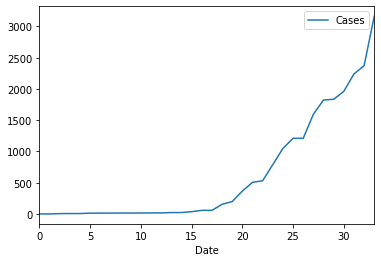

In [3]:
df.plot(x ='Date', y='Cases')

**MODELO POLINOMIAL**

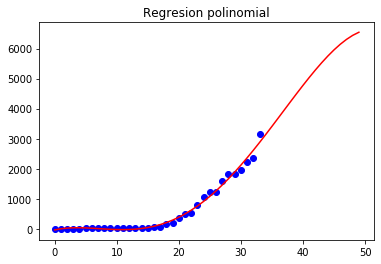

In [4]:
X = df.iloc[:, 0:1].values 
y = list(df.iloc [:, 1])
lin = LinearRegression() 
  
lin.fit(X, y) 
poly = PolynomialFeatures(degree = 4) 
X_poly = poly.fit_transform(X) 
  
poly.fit(X_poly, y) 
lin2 = LinearRegression() 
lin2.fit(X_poly, y) 
plt.scatter(X, y, color = 'blue') 
##Prediccion de 50 dias mas
X1 = np.array(range(0,50))
pre = lin2.predict(poly.fit_transform(X1.reshape(-1, 1)))
plt.plot(X1, pre, color = 'r') 
plt.title('Regresion polinomial') 
               
plt.show() 

In [5]:
X1 = np.array(50)
pre = lin2.predict(poly.fit_transform(X1.reshape(-1, 1)))
print(pre)

[6612.09693282]


0.3999999406038575
0.4


Text(0, 0.5, 'Numero de Personas')

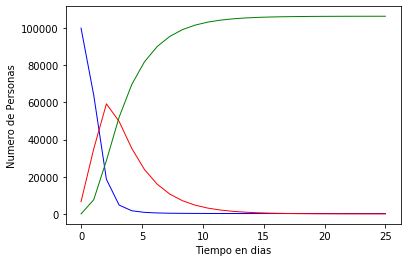

In [6]:
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.integrate import odeint

def loss(point, data, s0, i0, r0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s0,i0,r0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))
N=17096
i0=6612
r0=0
s0=100000
data=list(df.iloc [:, 1])
optimal = minimize(loss, [0.001, 0.001], args=(data,s0,i0, r0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])   
beta, gamma = optimal.x
print(beta)
print(gamma)
t = np.linspace(0, 25, 25)
# Las ecuaciones diferenciales del modelo SIR..
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Vector de condiciones iniciales
y0 = s0,i0,r0
# Integre las ecuaciones SIR en la cuadrícula de tiempo, t. A traves de la funcion odeint()
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T # Obtenicion de resultados


#  Trace los datos en tres curvas separadas para S (t), I (t) y R (t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S, 'b', alpha=1, lw=1, label='Sustible de infeccion')
ax.plot(t, I, 'r', alpha=1, lw=1, label='Infectados')
ax.plot(t, R, 'g', alpha=1, lw=1, label='Recuperados')
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')

1e-08
1e-08


Text(0, 0.5, 'Numero de Personas')

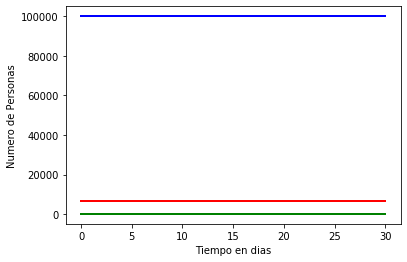

In [7]:
def loss(point, data, recovered,s0,i0, r0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s0,i0, r0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    # Put more emphasis on recovered people
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2
N=17096
i0=6612
r0=168
s0=100000
recovered=list(df.iloc [:, 2])
data=list(df.iloc [:, 1])
optimal = minimize(loss, [0.001, 0.001], args=(data, recovered,s0,i0,r0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
beta, gamma = optimal.x
print(beta)
print(gamma)
t = np.linspace(0,30,30)
# Las ecuaciones diferenciales del modelo SIR..
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Vector de condiciones iniciales
y0 = s0,i0,r0
# Integre las ecuaciones SIR en la cuadrícula de tiempo, t. A traves de la funcion odeint()
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T # Obtenicion de resultados


#  Trace los datos en tres curvas separadas para S (t), I (t) y R (t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S, 'b', alpha=1, lw=2, label='Sustible de infeccion')
ax.plot(t, I, 'r', alpha=1, lw=2, label='Infectados')
ax.plot(t, R, 'g', alpha=1, lw=2, label='Recuperados')
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')

**EN PROGRESO!!!!!!!!!!**